# Classify using start=0 mid = 1 end = 2

In [1]:
import sys
import pandas as pd
import numpy as np

## 1. Read dataset

In [2]:
dirname = '../../datasets/marked_start_mid_end/'
suffix = '.csv'

def read_from_file( file_name, rand_num):
    
    try:
        full_file_name = file_name + str(rand_num)

        file_at_path = dirname + full_file_name + suffix

        data = pd.read_csv(file_at_path)
        
        return data, full_file_name
    
    except IOError as e:
        print(e)
        return None,None

## 2. Read files

### 2.1 The A series (A1-A159)

In [3]:
raw_data, full_file_name = read_from_file("A", 1)

#print(full_file_name)
print(raw_data.shape)

for i in range(2,160):
    input_data, full_file_name = read_from_file("A", i)
    
    if(full_file_name is None):
        continue
    else:
        #print(full_file_name)
        raw_data = raw_data.append(input_data, ignore_index = True)

print(raw_data.shape)

(229, 28)
[Errno 2] No such file or directory: '../../datasets/marked_start_mid_end/A60.csv'
[Errno 2] No such file or directory: '../../datasets/marked_start_mid_end/A107.csv'
(33093, 28)


### 2.2 The B series (B1-B22)

In [4]:
for i in range(1,23):
    input_data, full_file_name = read_from_file("B", i)
    
    if(full_file_name is None):
        continue
    else:
        #print(full_file_name)
        raw_data = raw_data.append(input_data, ignore_index = True)

print(raw_data.shape)

(38488, 28)


In [5]:
start_0, mid_1, end_2 = np.bincount(raw_data['status'])
print(
    'Frames:\n    Total: {}\n    Before: {} ({:.2f}% of total)\n    During: {} ({:.2f}% of total)\n    After: {} ({:.2f}% of total)\n'
    .format(
      len(raw_data), 
      start_0,
      start_0 / len(raw_data),
      mid_1,
      mid_1 / len(raw_data),
      end_2,
      end_2 / len(raw_data)
    )
  )

Frames:
    Total: 38488
    Before: 8108 (0.21% of total)
    During: 23233 (0.60% of total)
    After: 7147 (0.19% of total)



In [6]:
cleaned_data = raw_data.copy()
cleaned_data.pop( 'FrameNo')

0          0
1          1
2          2
3          3
4          4
        ... 
38483    235
38484    236
38485    237
38486    238
38487    239
Name: FrameNo, Length: 38488, dtype: int64

In [7]:
# Use a utility from sklearn to split and shuffle our dataset.

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(cleaned_data, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_data.pop('status'))
val_labels = np.array(val_data.pop('status'))
test_labels = np.array(test_data.pop('status'))

train_features = np.array(train_data)
val_features = np.array(val_data)
test_features = np.array(test_data)

### Normalization
Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (24632,)
Validation labels shape: (6158,)
Test labels shape: (7698,)
Training features shape: (24632, 26)
Validation features shape: (6158, 26)
Test features shape: (7698, 26)


In [9]:
import tensorflow as tf
from tensorflow import keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [11]:
def make_model(metrics=METRICS, optimizer='Adam',loss = 'categorical_crossentropy'):
    model = keras.Sequential([
        keras.layers.Dense(units=16, activation='relu',input_dim=train_features.shape[-1]),
        keras.layers.Dense(32, activation='relu' ),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    #keras.losses.BinaryCrossentropy()
    return model

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1,patience=10,mode='max',restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                432       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,009
Trainable params: 1,009
Non-trainable params: 0
_________________________________________________________________


# Checkpoint the initial weights

In [14]:
import os
import tempfile

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [15]:
history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
13/13 [==============================] - 2s 62ms/step - loss: 0.0000e+00 - tp: 4576.8571 - fp: 207.2143 - tn: 2927.3571 - fn: 7217.7143 - accuracy: 0.4550 - precision: 0.9512 - recall: 0.3924 - auc: 0.6968 - prc: 0.9080 - val_loss: 0.0000e+00 - val_tp: 1764.0000 - val_fp: 59.0000 - val_tn: 1272.0000 - val_fn: 3063.0000 - val_accuracy: 0.4383 - val_precision: 0.9676 - val_recall: 0.3654 - val_auc: 0.7028 - val_prc: 0.9070
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - tp: 4120.3571 - fp: 114.6429 - tn: 3005.4286 - fn: 7688.7143 - accuracy: 0.4254 - precision: 0.9736 - recall: 0.3476 - auc: 0.7018 - prc: 0.9101 - val_loss: 0.0000e+00 - val_tp: 1694.0000 - val_fp: 65.0000 - val_tn: 1266.0000 - val_fn: 3133.0000 - val_accuracy: 0.4238 - val_precision: 0.9630 - val_recall: 0.3509 - val_auc: 0.7031 - val_prc: 0.9051
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - tp: 3985.8571 - fp: 136.2143 - tn: 2964.6

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [17]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0
tp :  2157.0
fp :  68.0
tn :  1562.0
fn :  3911.0
accuracy :  0.4319303631782532
precision :  0.9694381952285767
recall :  0.35547131299972534
auc :  0.7018256783485413
prc :  0.908697783946991



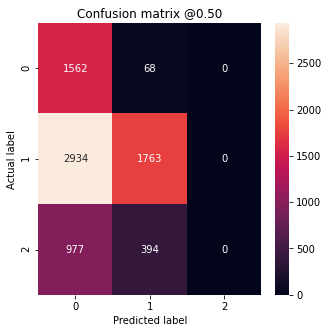

In [18]:
results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

#plot_cm(train_labels, train_predictions_baseline)

In [19]:
# Class weights

In [20]:
weight_for_0 = (1 / start_0)*(len(raw_data))/3.0 
weight_for_1 = (1 / mid_1)*(len(raw_data))/3.0
weight_for_2 = (1 / end_2)*(len(raw_data))/3.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 1.58
Weight for class 1: 0.55
Weight for class 2: 1.80


In [21]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
13/13 [==============================] - 2s 76ms/step - loss: 0.0000e+00 - tp: 6910.1429 - fp: 320.6429 - tn: 4437.0000 - fn: 10959.3571 - accuracy: 0.4482 - precision: 0.9554 - recall: 0.3846 - auc: 0.6976 - prc: 0.9078 - val_loss: 0.0000e+00 - val_tp: 1950.0000 - val_fp: 108.0000 - val_tn: 1223.0000 - val_fn: 2877.0000 - val_accuracy: 0.4563 - val_precision: 0.9475 - val_recall: 0.4040 - val_auc: 0.7032 - val_prc: 0.9070
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - tp: 4658.2857 - fp: 244.7143 - tn: 2873.2857 - fn: 7152.8571 - accuracy: 0.4478 - precision: 0.9498 - recall: 0.3937 - auc: 0.6992 - prc: 0.9093 - val_loss: 0.0000e+00 - val_tp: 1905.0000 - val_fp: 127.0000 - val_tn: 1204.0000 - val_fn: 2922.0000 - val_accuracy: 0.4437 - val_precision: 0.9375 - val_recall: 0.3947 - val_auc: 0.7030 - va

In [22]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0
tp :  2395.0
fp :  123.0
tn :  1507.0
fn :  3673.0
accuracy :  0.4521953761577606
precision :  0.9511517286300659
recall :  0.3946934640407562
auc :  0.7025331258773804
prc :  0.9088264107704163



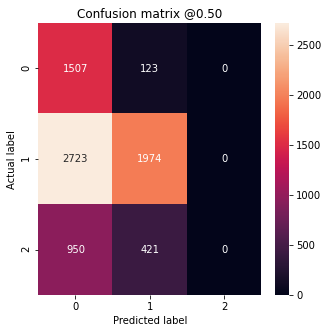

In [23]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

# over sample

In [24]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
train_features_sm, train_labels_sm = oversample.fit_resample(train_features, train_labels)
print(train_features_sm.shape,train_labels_sm.shape)

(44571, 26) (44571,)


In [25]:
os_model = make_model()
os_model.load_weights(initial_weights)
os_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                432       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,009
Trainable params: 1,009
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = os_model.fit(
    train_features_sm,
    train_labels_sm,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
22/22 [==============================] - 2s 37ms/step - loss: 0.0000e+00 - tp: 8323.8696 - fp: 780.3043 - tn: 8974.4783 - fn: 14064.1304 - accuracy: 0.4516 - precision: 0.9161 - recall: 0.3739 - auc: 0.6739 - prc: 0.8549 - val_loss: 0.0000e+00 - val_tp: 1905.0000 - val_fp: 117.0000 - val_tn: 1214.0000 - val_fn: 2922.0000 - val_accuracy: 0.4461 - val_precision: 0.9421 - val_recall: 0.3947 - val_auc: 0.7057 - val_prc: 0.9067
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - tp: 5850.3043 - fp: 721.6957 - tn: 7392.5217 - fn: 10480.2609 - accuracy: 0.4405 - precision: 0.8923 - recall: 0.3578 - auc: 0.6732 - prc: 0.8341 - val_loss: 0.0000e+00 - val_tp: 1895.0000 - val_fp: 138.0000 - val_tn: 1193.0000 - val_fn: 2932.0000 - val_accuracy: 0.4375 - val_precision: 0.9321 - val_recall: 0.3926 - val_auc: 0.7012 - val_prc: 0.8994
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - tp: 6027.4783 - fp: 844.6957 - tn: 72

In [27]:
train_predictions_os = os_model.predict(train_features_sm, batch_size=BATCH_SIZE)
test_predictions_os = os_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0
tp :  2351.0
fp :  146.0
tn :  1484.0
fn :  3717.0
accuracy :  0.44219276309013367
precision :  0.9415298104286194
recall :  0.38744232058525085
auc :  0.7046233415603638
prc :  0.9081960916519165



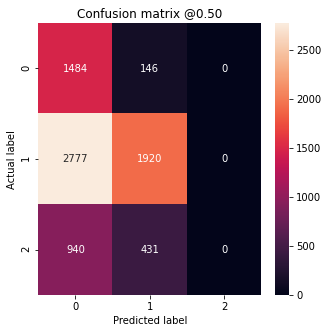

In [28]:
results = os_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(os_model.metrics_names, results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_os)

#plot_cm(train_labels, train_predictions_baseline)